## Note: Unless you're using google drive to mount the data file, the code in the first three cells is NOT FOR YOU. 

In [ ]:
# installing and importing libs like Pydrive, to be able to read the file directly from the drive
!pip install -U -q PyDrive 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# authentication for the drive users to be able to read the data file
# when you run this code, it will ask you to authenticate, it will render a link below, click it!
# sign in with your email, that is used in the drive
# after signing in, it will give you an authentication code, put it in the required area below and press enter
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fileDownloaded = drive.CreateFile({'id':'156BHbntOJ-68X3DThXhblSQ7d9P4N0H6'})
fileDownloaded.GetContentFile('HEC_days.csv')

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as pyoff
import plotly.graph_objects as go
from sklearn import preprocessing
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pd.set_option('display.max_row', 1000)

# Day Data 

In [ ]:
HEC_df = pd.read_csv('HEC_day.csv')
HEC_df.head()

,Unnamed: 0,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date
0,1,2749.004,148.166,345785.73,11400.4,0.0,352.0,5880.0,2007-01-01
1,2,2759.738,142.508,347092.81,11489.2,2461.0,2739.0,12355.0,2008-01-01
2,3,1406.692,112.668,349683.93,5975.8,765.0,3845.0,2803.0,2009-01-01
3,4,1824.760,150.264,346164.68,7678.8,1170.0,386.0,13145.0,2007-02-01
4,5,1534.652,179.250,346118.79,6505.4,336.0,280.0,7241.0,2008-02-01


In [ ]:
HEC_df.shape

(1096, 9)

In [ ]:
HEC_df.dtypes

Date                    object
Global_active_power    float64
dtype: object

In [ ]:
HEC_df['Date'] = pd.to_datetime(HEC_df['Date'])

In [ ]:
HEC_df = HEC_df[['Date', 'Global_active_power']]

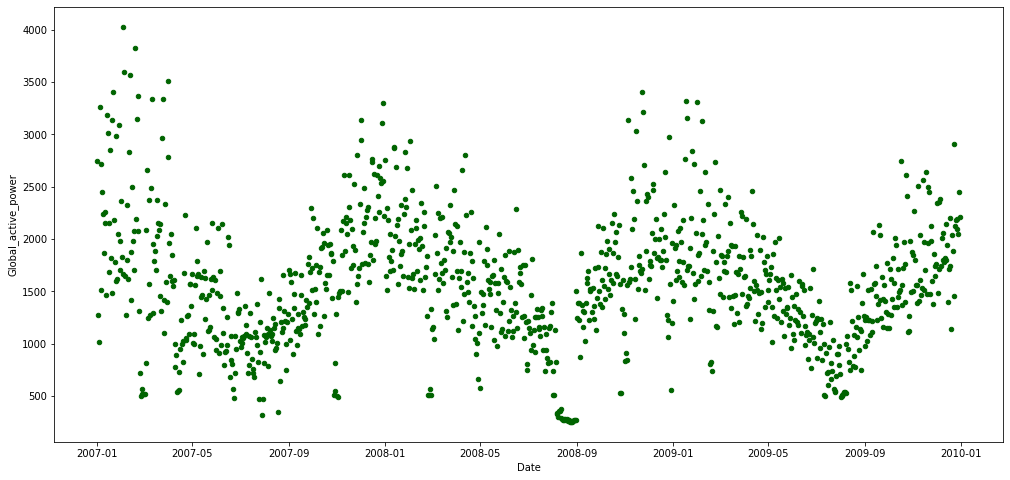

In [ ]:
HEC_df.plot.scatter(x ='Date', y= 'Global_active_power', figsize=(17, 8),color="DarkGreen")

# Data Preparation

In [ ]:
# check for null values
HEC_df.isna().sum()

In [ ]:
# check columns
HEC_df.columns

In [ ]:
# remove unwanted columns
HEC_df = HEC_df.drop('Unnamed: 0', axis=1)
HEC_df.head()

In [ ]:
# change date column's type 
HEC_df['Date'] = pd.to_datetime(HEC_df['Date'])


In [ ]:
# sort the data by date
HEC_df = HEC_df.sort_values('Date')
HEC_df.head()

# Data Visualization 

In [ ]:
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=['ds'],y=merged['yhat'],y0=merged['y'], name='Predicted',))
fig.update_layout(
    title="Actual vs Predicted Daily Power Usage in 2009",
    xaxis_title="Date",
    yaxis_title="Power Usage(Kilowatts)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"
    )
)
fig.show()

# Modeling with FB Prophet

In [ ]:
# subset the data into two columns for the modeling
mod_df = HEC_df[['Date', 'Global_active_power']].rename(columns = { 'Date': 'ds', 'Global_active_power':'y'})
mod_df.head()

,ds,y
0,2007-01-01,2749.004
36,2007-01-02,1269.236
72,2007-01-03,1014.054
108,2007-01-04,3259.412
144,2007-01-05,2713.364


In [ ]:
# split data into train and test 
mod_train = mod_df[mod_df['ds'].dt.year != 2009]
mod_test = mod_df[mod_df['ds'].dt.year == 2009]

In [ ]:
# print both data sets shapes
print(f'train: {mod_train.shape}')
print(f'test: {mod_test.shape}')

train: (731, 2)
test: (365, 2)


In [ ]:
# a tail of the test data
mod_test.tail()

,ds,y
1083,2009-05-31,956.890
1086,2009-07-31,975.830
1089,2009-08-31,1265.522
1092,2009-10-31,1875.942
1095,2009-12-31,2211.892


In [ ]:
# build prophet and fit the data
mod = Prophet(interval_width= 0.95)
mod.add_country_holidays(country_name='FR')
mod.make_all_seasonality_features
mod.fit(mod_train)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# predict the test data
fcst = mod.predict(mod_test)

In [ ]:
# results' head
fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Armistice 1918,Armistice 1918_lower,Armistice 1918_upper,Armistice 1945,Armistice 1945_lower,Armistice 1945_upper,Ascension,Ascension_lower,Ascension_upper,Assomption,Assomption_lower,Assomption_upper,Fête du Travail,Fête du Travail_lower,Fête du Travail_upper,Fête nationale,Fête nationale_lower,Fête nationale_upper,Jour de l'an,Jour de l'an_lower,Jour de l'an_upper,Lundi de Pentecôte,Lundi de Pentecôte_lower,Lundi de Pentecôte_upper,Lundi de Pâques,Lundi de Pâques_lower,Lundi de Pâques_upper,Noël,Noël_lower,Noël_upper,Toussaint,Toussaint_lower,Toussaint_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-01-01,1480.811995,1681.998083,3459.338922,1480.811995,1480.811995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,695.454412,695.454412,695.454412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1099.138675,1099.138675,1099.138675,695.454412,695.454412,695.454412,-167.351301,-167.351301,-167.351301,571.035564,571.035564,571.035564,0.0,0.0,0.0,2579.950670
1,2009-01-02,1480.451749,1102.240965,2818.536200,1480.449306,1480.456448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,497.747781,497.747781,497.747781,0.000000,0.000000,0.000000,-66.585702,-66.585702,-66.585702,564.333482,564.333482,564.333482,0.0,0.0,0.0,1978.199530
2,2009-01-03,1480.091503,1375.592926,3206.071187,1480.081403,1480.104770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,778.609136,778.609136,778.609136,0.000000,0.000000,0.000000,222.494632,222.494632,222.494632,556.114504,556.114504,556.114504,0.0,0.0,0.0,2258.700639
3,2009-01-04,1479.731257,1391.586394,3222.831719,1479.710409,1479.751084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,790.013532,790.013532,790.013532,0.000000,0.000000,0.000000,243.329834,243.329834,243.329834,546.683698,546.683698,546.683698,0.0,0.0,0.0,2269.744789
4,2009-01-05,1479.371011,983.193313,2729.822790,1479.337012,1479.399909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,370.887605,370.887605,370.887605,0.000000,0.000000,0.000000,-165.507439,-165.507439,-165.507439,536.395044,536.395044,536.395044,0.0,0.0,0.0,1850.258616


In [ ]:
# subset the results dataframe of needed columns
prd = fcst[['ds','yhat', 'yhat_lower', 'yhat_upper']] 

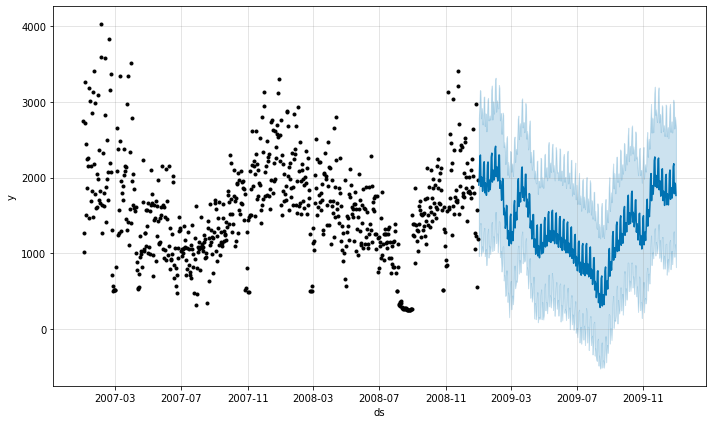

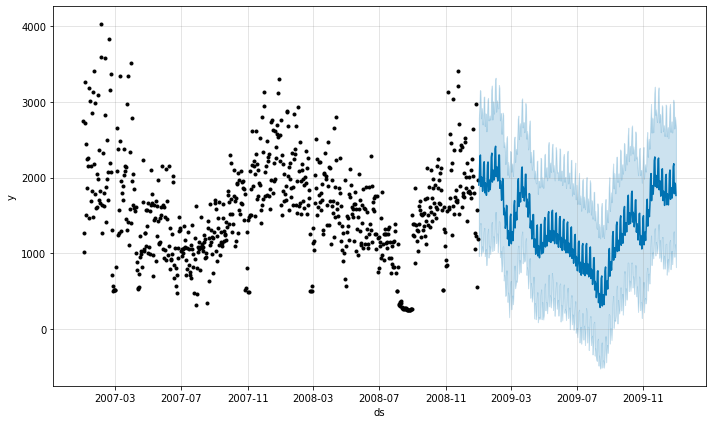

In [ ]:
# plot the predictions
mod.plot(fcst)

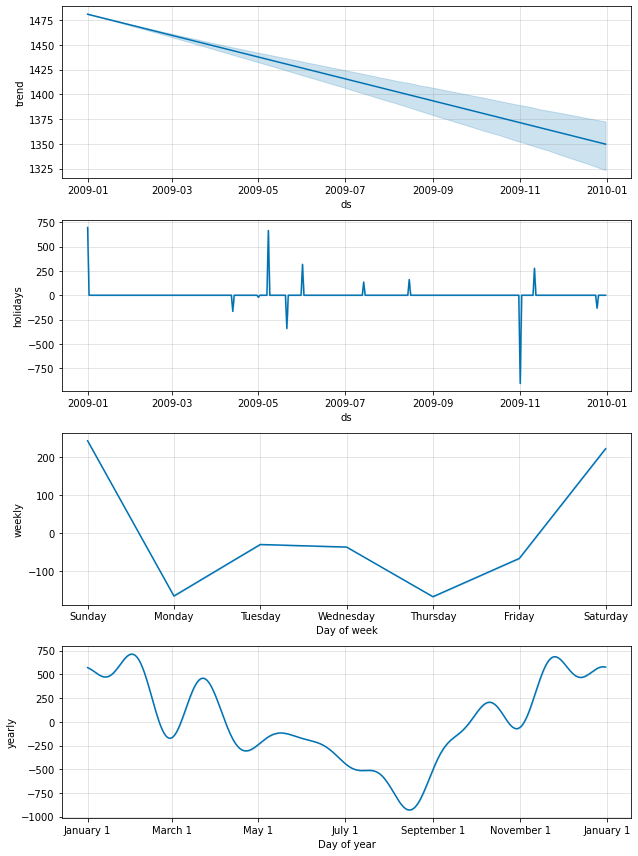

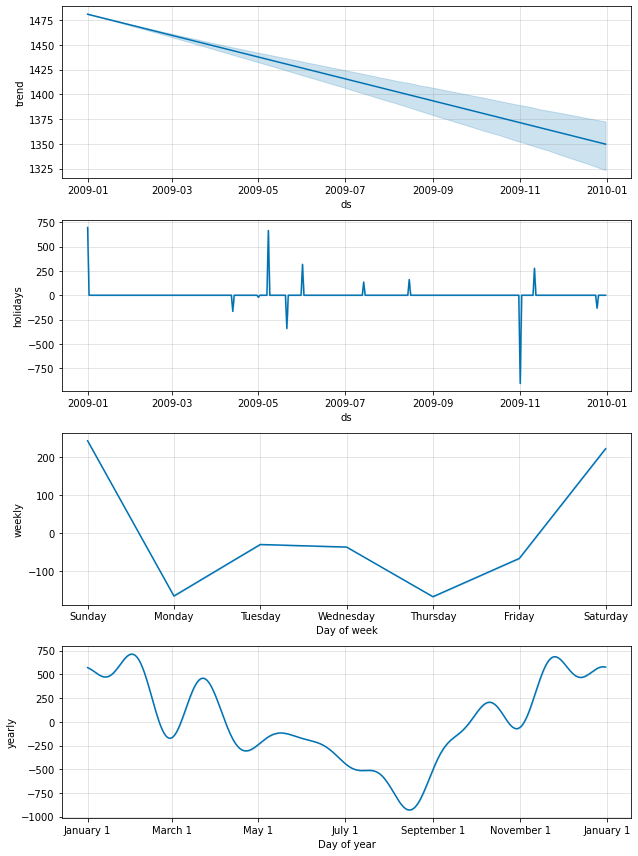

In [ ]:
# prophet components
Prophet.plot_components(mod,fcst)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



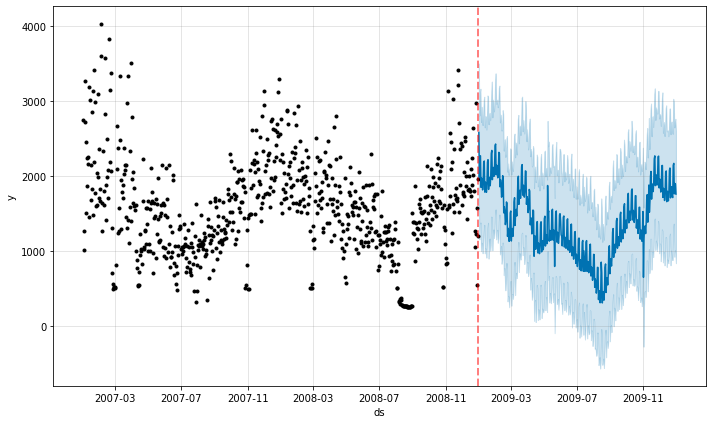

In [ ]:
# Plotting with Prophet built-in method
fig = mod.plot(fcst)
ax = fig.add_subplot(111)
ax.axvline(x=fcst['ds'].max() - pd.Timedelta('365 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

In [ ]:
# merge the predictions with actuals
merged = mod_test.merge(prd,left_on='ds', right_on='ds')
erged.head()

In [ ]:
# accuracy measures
MSE = mean_squared_error(merged.y, merged.yhat)
MAE = mean_absolute_error(merged.y, merged.yhat)
R2 = r2_score(merged.y, merged.yhat)
print(f'MSE : {MSE}, MAE: {MAE}, R2: {R2}')

MSE : 165677.89454945183, MAE: 311.421353399374, R2: 0.3719492545205707


In [ ]:
# plot the actuals versus predicted
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=merged['ds'],y=merged['yhat'],y0=merged['y'], name='Predicted',))
fig.add_trace(go.Scatter(x=merged['ds'],y=merged['y'], name='Actual'))
fig.update_layout(
    width=1000,
    height=400,
    title="Actual vs Predicted Daily Power Usage in 2009",
    xaxis_title="Date",
    yaxis_title="Power Usage(Kilowatts)",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="Black"
    )
)
fig.show()